In [1]:
import numpy as np

from kafka_infra.MongoDbClient import MongoDbClient

client = MongoDbClient("ann_recognized_samples")

In [8]:
domain = np.arange(0,1,0.01)

In [9]:
print(domain)

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99]


In [10]:
def define_pipeline(x):
    pipeline = [
        {
            "$lookup": {
                "from": "generated_samples",
                "localField": "sample_id",
                "foreignField": "sample_id",
                "as": "generated_sample_data"
            }
        },
        {
            "$unwind": "$generated_sample_data"
        },
        {
            "$project": {
                "sample_id": 1,
                "predicted_value": 1,
                "duration": 1,
                "normal_data": "$generated_sample_data.normal_data"
            }
        },
        {
            "$facet": {
                "normal_data_total": [
                    {
                        "$match": {
                            "normal_data": 1
                        }
                    },
                    {
                        "$count": "count"
                    }
                ],
                "normal_data_recognized": [
                    {
                        "$match": {
                            "normal_data": 1,
                            "predicted_value": { "$gte": x }
                        }
                    },
                    {
                        "$count": "count"
                    }
                ],
                "anomalous_data_total": [
                    {
                        "$match": {
                            "normal_data": 0
                        }
                    },
                    {
                        "$count": "count"
                    }
                ],
                "anomalous_data_recognized": [
                    {
                        "$match": {
                            "normal_data": 0,
                            "predicted_value": { "$lt": x }
                        }
                    },
                    {
                        "$count": "count"
                    }
                ]
            }
        },
        {
            "$project": {
                "normal_data_count": { "$arrayElemAt": ["$normal_data_total.count", 0] },
                "correct_recognized_normal_data": { "$arrayElemAt": ["$normal_data_recognized.count", 0] },
                "anomalous_data_count": { "$arrayElemAt": ["$anomalous_data_total.count", 0] },
                "correct_recognized_anomalous_data": { "$arrayElemAt": ["$anomalous_data_recognized.count", 0] }
            }
        }
    ]

    return pipeline

In [11]:
sample_details = []
normal_data_count = -1
anomalous_data_count = -1

In [12]:
for x in domain:
    pipeline = define_pipeline(x)
    result = client.aggregate(pipeline)
    for doc in result:
        if normal_data_count == -1:
            normal_data_count = doc['normal_data_count']
        if anomalous_data_count == -1:
            anomalous_data_count = doc['anomalous_data_count']
        try:
            doc['correct_recognized_normal_data']
        except KeyError:
            doc['correct_recognized_normal_data'] = 0
        try:
            doc['correct_recognized_anomalous_data']
        except KeyError:
            doc['correct_recognized_anomalous_data'] = 0
        sample_details.append({
            'factor': x,
            'correct_recognized_normal_data': doc['correct_recognized_normal_data'],
            'correct_recognized_anomalous_data': doc['correct_recognized_anomalous_data']
        })

In [13]:
print(sample_details)
correct_recognized_normal_samples_ratio = []
correct_recognized_anomalous_samples_ratio = []

for sample in sample_details:
    correct_recognized_normal_samples_ratio.append(sample['correct_recognized_normal_data'] / normal_data_count)
    correct_recognized_anomalous_samples_ratio.append(
        sample['correct_recognized_anomalous_data'] / anomalous_data_count)

print(correct_recognized_normal_samples_ratio)

[{'factor': 0.0, 'correct_recognized_normal_data': 814, 'correct_recognized_anomalous_data': 0}, {'factor': 0.01, 'correct_recognized_normal_data': 814, 'correct_recognized_anomalous_data': 0}, {'factor': 0.02, 'correct_recognized_normal_data': 814, 'correct_recognized_anomalous_data': 0}, {'factor': 0.03, 'correct_recognized_normal_data': 812, 'correct_recognized_anomalous_data': 0}, {'factor': 0.04, 'correct_recognized_normal_data': 807, 'correct_recognized_anomalous_data': 0}, {'factor': 0.05, 'correct_recognized_normal_data': 800, 'correct_recognized_anomalous_data': 1}, {'factor': 0.06, 'correct_recognized_normal_data': 784, 'correct_recognized_anomalous_data': 9}, {'factor': 0.07, 'correct_recognized_normal_data': 763, 'correct_recognized_anomalous_data': 12}, {'factor': 0.08, 'correct_recognized_normal_data': 749, 'correct_recognized_anomalous_data': 13}, {'factor': 0.09, 'correct_recognized_normal_data': 719, 'correct_recognized_anomalous_data': 15}, {'factor': 0.1, 'correct_re

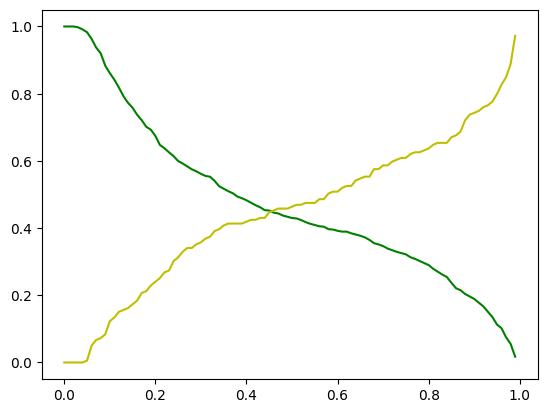

In [14]:
import matplotlib.pyplot as plt

plt.plot(domain, correct_recognized_normal_samples_ratio, 'g')
plt.plot(domain, correct_recognized_anomalous_samples_ratio, 'y')
plt.show()

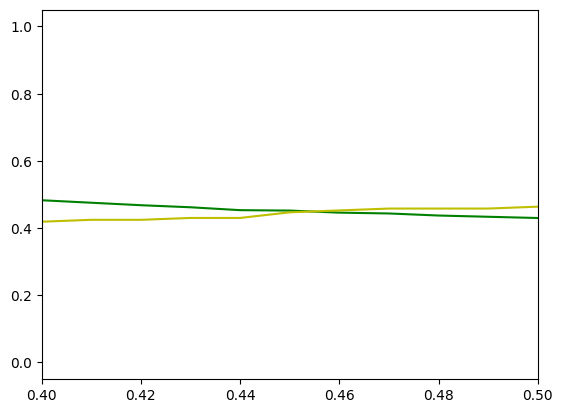

In [17]:
plt.plot(domain, correct_recognized_normal_samples_ratio, 'g')
plt.plot(domain, correct_recognized_anomalous_samples_ratio, 'y')
plt.xlim(0.4, 0.5)
plt.show()

In [19]:
min_difference = float('inf')
for i in range(0, len(correct_recognized_normal_samples_ratio)):
    # Compute the absolute difference between the current pair of values
    difference = abs(correct_recognized_normal_samples_ratio[i] - correct_recognized_anomalous_samples_ratio[i])

    # Check if this pair is closer than the previously found closest pair
    if difference < min_difference:
        # If so, update the closest pair and the minimum difference
        closest_pair = (correct_recognized_normal_samples_ratio[i], correct_recognized_anomalous_samples_ratio[i])
        index = i
        min_difference = difference

print(index)
print(np.mean(closest_pair))

45
0.449507913195064
